# Segmentación de tejido pulmonar


***
El presente notebook contiene una explicación detallada del proceso de segmentación de tejido pulmonar en imágenes de CT a partir de archivos DICOM, mediante el algoritmo de watershed basado en marcadores.

## Objetivos

```
- Guardar imágenes de un examen de CT en un formato accesible y de fácil manejo en python.
- Aplicar el algoritmo de watershed basado en marcadores para segmetar pulmones.
- Segmentar tejido pulmonar en imágenes de Tomografía Computarizada de tórax.
- Implementar funciones que permitan automatizar procesos y eliminar código innecesario. 
- Graficar las imágenes segmentadas.

```

## Introducción

La segmentación de pulmones es un paso previo al procesamiento de la mayoría de sistemas CAD (Diagnostico Asistido por Computadora). El proceso que se aplicará para la segmentación es un método automático que utiliza principalmente la transformación de Watershed basada en marcadores en 2D, con pequeñas modificaciones y que fue descrito por primera vez en el artículo <a href="https://www.semanticscholar.org/paper/Automatic-lung-segmentation-in-CT-images-using-Shojaii-Alirezaie/03002d15a3af26c6d961286d4e039787622a8fbe">DOI:10.1109/ICIP.2005.1530294</a>.


A continuación se presenta el flujo de trabajo para la segmentación pulmonar en imágenes DICOM de TC de tórax, este flujo de trabajo muestra la estructura que tiene el presente notebook.

<img src="imagenes/Flujo_segmentacion.png"> 
 

>**Nota**: Las funciones que se diseñaron para automatizar ciertos procesos y para que  el presente notebook sea mas interactivo y fácil de entender,  fueron guardadas en el archivo **`segmentacion_pulmonar.py`** y son importadas al notebook como **`s_p`**.
Además se utilizará el módulo creado anteriormente para la visualización y manipulación de las imágenes DICOM llamado **`imprimir_imagen`** y es importado a este notebook como **`imp`**.

## Librerías y módulos


Las bibliotecas que son necesarias para este proyecto son las siguientes:


- *pydicom* para leer los atributos de archivos DICOM.
- *numpy* para la manipulación de las matrices.
- *matplotlib* para gráficar datos.
- *imprimir_imagen* para manipular imágenes de CT de archivos dicom.
- *scipy.ndimage* para el procesamiento de imágenes multidimensionales.
- *skimage* para procesamiento de imágenes
- *os* para manipulación de directorios
- *segmentacion_pulmonar*

In [1]:
import pydicom
import numpy as np
import matplotlib.pylab as plt
import imprimir_imagen as imp
import scipy.ndimage as ndimage
import os
import segmentacion_pulmonar as s_p


from skimage import measure, morphology, segmentation

## Selección de exámenes (RADIOTERAPIA DE TÓRAX)

Para realizar la segmentación de tejido pulmonar se utilizaró los examenes que comprendan la zona torácica, con este fin se realizó un filtraje de las imágenes por medio del atributo Protocol name con el tag (0018,1030), un atributo llenado por el operador con las condiciones bajo las cuales se realizó la Serie, se eligio las imágenes con el elemento 10.7 RADIOTERAPIA TORAX, utilizadas en la planificación del tratamiento de radioterapia. También se utilizará el elemento 6.1 ABDOMEN Y PELVIS de un TC corporal.

## Lectura de la imagen
La lectura de los datos de un archivo DICOM para la segmentación sigue el mismo proceso que se realizó para la visualización, así mismo se extrae algunos atributos que son necesarios para la reconstrucción de la imagen, todo este proceso lo puede encontrar en el notebook de jupyter  <a href="https://github.com/jennifer95/visualizacion-segmentancion-pulmonar-DICOM-python/blob/main/Visualizaci%C3%B3n%20de%20im%C3%A1genes%20DICOM.ipynb">Visualización de imágenes DICOM.ipynb</a>. En el archivo `imprimir_imagen` se diseñaron funciones que permiten realizar todo este proceso de una manera muy simplificada y automática.


## Obtención, transformación de unidades y corrección de la matriz N × M × M
En esta sección se obtiene una matriz de N × M × M dimensiones producto de la lectura de la matriz de píxeles de cada uno de los archivos DICOM de un mismo examen y de su posterior apilamiento, a la cual  llamamos matriz 3D, luego se realiza el cambio de unidades a Hounsfield y finalmente se realiza la corrección de píxeles,
de una manera similar a la que se realizó para el proceso de visualización.


In [2]:
ruta = 'datos-torax-A/paciente3-A' # ruta de la imagen
imagen = imp.extrac_matrix(imp.load_scan(ruta)) # cargamos las imágenes y extraemos la matriz
print('La matriz tiene las dimensiones de ' ,imagen.shape, 'lo que representa ', imagen.shape[0], 
      'cortes e imágenes de ', imagen.shape[1],'x',imagen.shape[2])

La matriz tiene las dimensiones de  (63, 512, 512) lo que representa  63 cortes e imágenes de  512 x 512


## Almacenamiento de la matriz

 La matriz de píxeles será almacenada en el formato NPY, un tipo de archivo de matriz NumPy creado por el paquete de software Python con la biblioteca NumPy.

In [3]:
try:
    os.mkdir('arrays') # crea una carpeta en la misma carpeta donde esta el notebook jupyter
except:
    print("La carpeta ya existe")
ruta_arrays = 'arrays/'
np.save(ruta_arrays + "arrays_{}.npy" .format('paciente3-A'), imagen) # almacenamos en NPY
imagen_procesada = np.load(ruta_arrays+'arrays_{}.npy'.format('paciente3-A')) # cargamos la matriz    

La carpeta ya existe


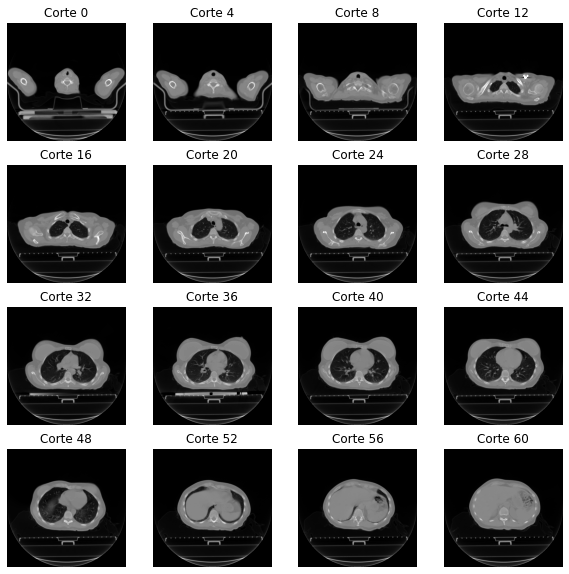

In [4]:
imp.muestra_datos(imagen, 4, 4, 0, 4, -1000, 1000) # visualización de una muestra de los datos

## Crear la imagen de gradiente
Para calcular el gradiente en la imagen se utilizará uno de los filtros de primera derivada más populares, el filtro de Sobel, este filtro será aplicado en la imagen de TC pulmonar original tanto en dirección horizontal como vertical.

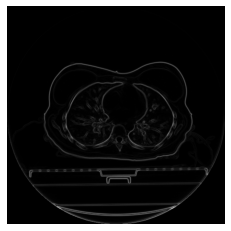

In [5]:
image= imagen[40]
# aplicamos el operador de sobel en X y Y
sobel_dx = ndimage.sobel(image, 1)
sobel_dy = ndimage.sobel(image, 0)
sobel_gradient = np.hypot(sobel_dx, sobel_dy) # calculamos el norma
sobel_gradient *= 255.0 / np.max(sobel_gradient) # normalizamos
plt.imshow(sobel_gradient, cmap='gray')
plt.axis('off')
plt.show()

In [6]:
def image_gradiente(image):
    sobel_dx = ndimage.sobel(image, 1)
    sobel_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_dx, sobel_dy) # calculamos el norma
    sobel_gradient *= 255.0 / np.max(sobel_gradient) # normalizamos
    return sobel_gradient

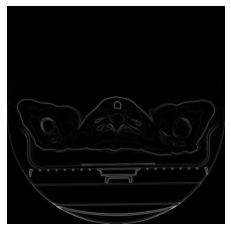

In [7]:
image = imagen[8]
sobel_gradient = image_gradiente(image)
plt.imshow(sobel_gradient, cmap='gray')
plt.axis('off')
plt.show()

Para utilizar la segmentación de Watershed basada en marcadores, necesitamos identificar dos marcadores. Un marcador interno, donde se tenga seguridad que dicha zona pertenece a tejido pulmonar y un marcador externo, esta regíon se carácteriza porque definitivamente está fuera de la región de interes que en este caso es los pulmones. Comenzamos creando el marcador interno mediante el umbral de la imagen y eliminando todas las regiones menos las mas grandes.

## Generación del Marcador interno

El marcador interno se caracteriza por ser una zona donde se tiene certeza de que pertenece a la región que se desea segmentar o región de interes (ROI) que este caso es los pulmones. Para generar el marcador se utiliza los valores respectivos en unidades Hounsfield que corresponden a la zona pulmonar. 
Dado que en las imágenes de TC pulmonar el aire aparecerá con una intensidad media de aproximadamente -1000 Unidades Hounsfield (HU), y que la región pulmonar estará en el rango de -1000 a -400 HU y la pared torácica, la sangre y los huesos serán mucho más densos muy por encima de -400 HU. Para especificar los marcadores internos, se seleccionan las regiones con valores de píxeles inferiores a -400 HU. 


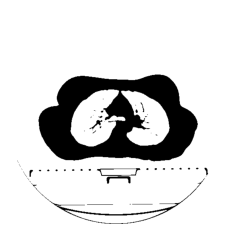

In [8]:
marker_internal = imagen[28] < -400 # evalua si el valor del píxel  cumple o no con la condición
plt.imshow(marker_internal, cmap='gray')
plt.axis('off')
plt.show()

La condición que se aplicó anteriormente genera una matriz booleana, donde todos los elementos que cumplen con la condición tendrán como salida `TRUE` o 1, mientras que los píxeles que no cumplan con la condición tendrán un valor de `FALSE` o 0. Al utilizar la función `plt.imshow` y la paleta de colores `gray` tendremos que para `TRUE` le corresponde el color blanco y para `FALSE` le corresponde el color negro.  Como el fondo de la imagen corresponde a aire tenemos como resultado una imagen con una región que rodea al cuerpo que según la condición aplicada pertenece a la zona de los pulmones, como evidentemente esta zona no pertenece a pulmones procedemos a eleminarla mediante la función  `segmentation.clear_border` de la biblioteca skimage, que borra los objetos conectados al borde de la imagen.

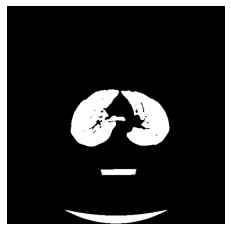

In [9]:
marker_internal = segmentation.clear_border(marker_internal)
plt.imshow(marker_internal, cmap=plt.cm.gray)
plt.axis('off')
plt.show()
#Borrar objetos conectados al borde de la imagen de la etiqueta.

Algunas zonas de la camilla son seleccionadas como región pulmonar por lo que se procede a eliminarlas mediante la función creada anteriormente en `imp.remov_cama`.

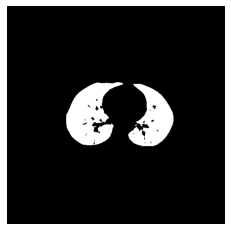

In [10]:
imagen =  imp.remov_cama(imagen, 370, 512) # eliminamos la camilla
marker_internal = imagen[40] < -400 # evalua si el valor del píxel cumple o no con la condición
marker_internal = segmentation.clear_border(marker_internal)
plt.imshow(marker_internal, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

Ahora etiquetamos cada una de los elementos presentes en la imagen, con el fin de identificar todos los elementos en la imagen y poder eleminar la tráquea y otras vías respiratorias.

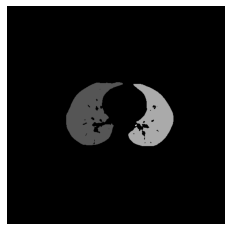

In [11]:
marker_internal_labels = measure.label(marker_internal) # encuentra cada objeto en la imagen y los etiqueta
plt.imshow(marker_internal_labels,  cmap=plt.cm.gray)
plt.axis('off')
plt.show()

hola


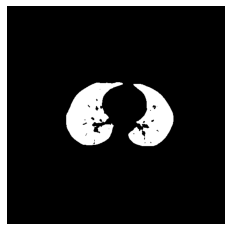

In [12]:
areas = [r.area for r in measure.regionprops(marker_internal_labels)] # Mide las propiedades de las regiones de imágenes etiquetadas.
areas.sort() # ordenamos 

if len(areas) == 1 and areas[0]< 300: # eliminamos areas muy pequeñas
    region = measure.regionprops(marker_internal_labels)
    for coordinates in region.coords:                
        marker_internal_labels[coordinates[0], coordinates[1]] = 0
    
elif len(areas) > 2: # de los 2 pulmones
    for region in measure.regionprops(marker_internal_labels):
        if region.area < areas[-2]: # el orden logra que solo se escoja los 2 mas grandes (correspondientes a pulomnes)
            for coordinates in region.coords:                
                marker_internal_labels[coordinates[0], coordinates[1]] = 0

                
marker_internal = marker_internal_labels > 0

plt.imshow(marker_internal,  cmap=plt.cm.gray)
plt.axis('off')
plt.show()

### Tratamiento para imágenes con tráquea

La ubicación de la tráquea se identifica buscando el objeto circular grande cerca del centro de los primeros cortes por lo que se utilizará el corte número 8.


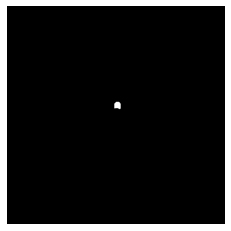

In [13]:
img_traquea = imagen[8]
marker_internal = imagen[8] < -400 # evalua si el valor del píxel cumple o no con la condición
marker_internal = segmentation.clear_border(marker_internal)
plt.imshow(marker_internal, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

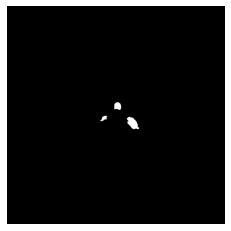

In [14]:
img_traquea = imagen[9]
marker_internal = imagen[9] < -400 # evalua si el valor del píxel cumple o no con la condición
marker_internal = segmentation.clear_border(marker_internal)
plt.imshow(marker_internal, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

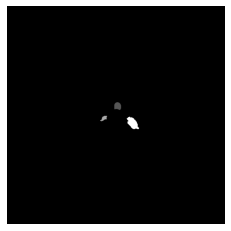

In [15]:
marker_internal_labels = measure.label(marker_internal) # encuentra cada objeto en la imagen y los etiqueta
plt.imshow(marker_internal_labels,  cmap=plt.cm.gray)
plt.axis('off')
plt.show()

hola hola


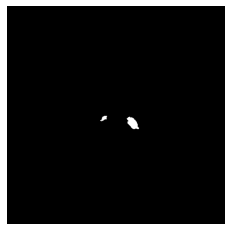

In [16]:
areas = [r.area for r in measure.regionprops(marker_internal_labels)] # Mide las propiedades de las regiones de imágenes etiquetadas.
areas.sort() # ordenamos 

if len(areas) == 1 and areas[0]< 300: # eliminamos areas muy pequeñas
    print('hohllaalal')
    region = measure.regionprops(marker_internal_labels)
    for coordinates in region.coords:                
        marker_internal_labels[coordinates[0], coordinates[1]] = 0
        
elif len(areas) >2  and areas[0] < 600 and areas[1] < 600 or areas[2] < 600 : # de los 2 pulmones
    print('hola hola')
    regiones = measure.regionprops(marker_internal_labels)
    coordenadas = [r.coords[0][0] for r in measure.regionprops(marker_internal_labels)] 
    coordenadas.sort() # ordenamos
    for region in regiones:
        if region.coords[0][0] < coordenadas[-2]: # el orden logra que solo se escoja los 2 mas grandes (correspondientes a pulomnes)
            for coordinates in region.coords:                
                marker_internal_labels[coordinates[0], coordinates[1]] = 0
                
elif len(areas) > 2: # de los 2 pulmones
    print(areas)
    print('hola')
    for region in measure.regionprops(marker_internal_labels):
        if region.area < areas[-2]: # el orden logra que solo se escoja los 2 mas grandes (correspondientes a pulomnes)
            for coordinates in region.coords:                
                marker_internal_labels[coordinates[0], coordinates[1]] = 0

                
marker_internal = marker_internal_labels > 0

plt.imshow(marker_internal,  cmap=plt.cm.gray)
plt.axis('off')
plt.show()

 ## Marcador Externo
 El marcador externo se crea mediante la dilatación morfológica del marcador interno con 2 iteraciones diferentes y restando los resultados. Se crea un marcador de cuenca superponiendo los 2 marcadores con diferentes valores de escala de grises.

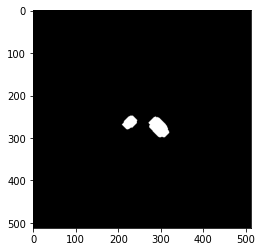

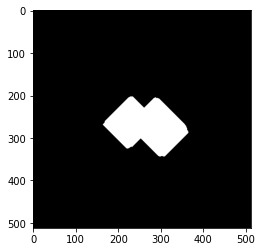

<ipython-input-17-59655210fcbc>:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  marker_watershed = np.zeros((512, 512), dtype=np.int)


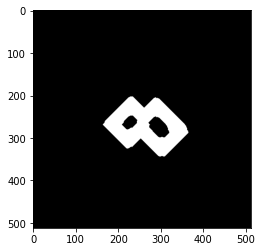

In [17]:
#Creation of the external Marker
external_a = ndimage.binary_dilation(marker_internal, iterations=10)
plt.imshow(external_a, cmap='gray')
plt.show()
external_b = ndimage.binary_dilation(marker_internal, iterations=55)
plt.imshow(external_b, cmap='gray')
plt.show()
marker_external = external_b ^ external_a
#Creation of the Watershed Marker matrix
marker_watershed = np.zeros((512, 512), dtype=np.int)
marker_watershed += marker_internal * 255
marker_watershed += marker_external * 128
plt.imshow(marker_external, cmap='gray')

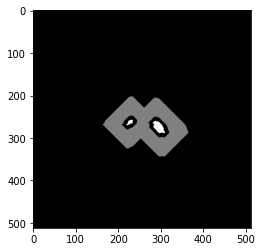

In [18]:
plt.imshow(marker_watershed, cmap='gray')
plt.show()

El fondo de la imagen de TC es casi negro (inferior a -400), por lo que hace un mínimo regional erróneo.


por lo que se utiliza los rango de tejido pulmonar, para definir esta zona se hace uso de los respectivos valores correspondientes a la zona que se requiere delimitar.  en unidades Hounsfield que es de -400HU además se tiene que el aire es de -1000 HU

[Top of Page](#top)
<img style="float: right;" src="https://fisica.epn.edu.ec/images/LOGO_fisica-01-01.png" alt="Space Telescope Logo" width="300px"/> 

In [19]:
np.hypot([1,2],[3,4])

array([3.16227766, 4.47213595])

In [20]:
1+3**2

10

In [21]:
import math
math.sqrt(10)

3.1622776601683795